# Model-Based Collaborative Filtering

**Model-Based Collaborative Filtering** is when we use the data that we have to make a model. We will then use this model to make a recomendataion  
- http://www.cs.carleton.edu/cs_comps/0607/recommend/recommender/modelbased.html

In [28]:
# import pandas library 
import pandas as pd 
  
# Get the data 
column_names = ['userId', 'movieId', 'rating', 'timestamp'] 
  
path = 'https://media.geeksforgeeks.org/wp-content/uploads/file.tsv'
  
df_ratings = pd.read_csv(path, sep='\t', names=column_names) 
  
# Check the head of the data 
df_ratings = df_ratings[['userId', 'movieId', 'rating']] 
df_ratings.head()

,userId,movieId,rating
0,0,50,5
1,0,172,5
2,0,133,1
3,196,242,3
4,186,302,3


In [29]:
# Check out all the movies and their respective IDs 
df_movies = pd.read_csv('https://media.geeksforgeeks.org/wp-content/uploads/Movie_Id_Titles.csv') 


In [30]:
df_movies.columns = ['movieId','title']
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


### Code Reference 
- https://github.com/nikitaa30/Recommender-Systems/blob/master/knn_recommender.ipynb

# Exercise 1 
- Make a model based recommender system by using the reference code above
- Make a prediction for the movie `Toy Story`

In [31]:

df_movies.head()
df_movies.shape

(1682, 2)

In [32]:
from scipy.sparse import csr_matrix
# pivot ratings into movie features
df_movie_features = df_ratings.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)

In [33]:
mat_movie_features = csr_matrix(df_movie_features.values)


In [34]:
df_movie_features.head()


userId,0,1,2,3,4,5,6,7,8,9,...,934,935,936,937,938,939,940,941,942,943
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
2,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
5,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)


In [36]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 944 unique users and 1682 unique movies in this data set


In [37]:
# get count
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
1,6111
2,11370
3,27145
4,34174
5,21203


In [38]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]

df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,1487805
1.0,6111
2.0,11370
3.0,27145
4.0,34174
5.0,21203


In [39]:
#log normalise to make it easier to interpret on a graph
import numpy as np
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,1487805,14.212812
1.0,6111,8.717846
2.0,11370,9.338734
3.0,27145,10.208948
4.0,34174,10.439220
5.0,21203,9.961898


Text(0, 0.5, 'number of ratings')

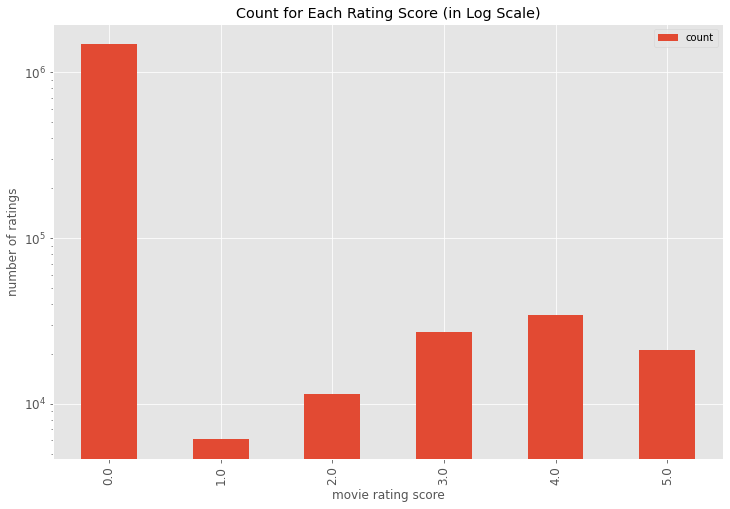

In [40]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [41]:
# get rating frequency
#number of ratings each movie got.
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,452
2,131
3,90
4,209
5,86


In [42]:
#now we need to take only movies that have been rated atleast 50 times to get some idea of the reactions of users towards it

popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (100003, 3)
shape of ratings data after dropping unpopular movies:  (83718, 3)


In [43]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
0,3
1,233
2,56
3,39
4,19


In [44]:
# filter data to come to an approximation of user likings.
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (100003, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (71687, 3)


In [45]:

# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
#map movie titles to images
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [46]:
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [48]:
from fuzzywuzzy import fuzz


In [49]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. 
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

In [50]:
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [52]:

my_favorite = 'Toy Story'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Toy Story
Found possible matches in our database: ['Toy Story (1995)']

Recommendation system start to make inference
......

Recommendations for Toy Story:
1: Empire Strikes Back, The (1980), with distance of 0.31856371082135015
2: Willy Wonka and the Chocolate Factory (1971), with distance of 0.3100845667680988
3: Fargo (1996), with distance of 0.309943336093487
4: Rock, The (1996), with distance of 0.3096151934239506
5: Mission: Impossible (1996), with distance of 0.30838879218992477
6: Star Trek: First Contact (1996), with distance of 0.3011410566256597
7: Raiders of the Lost Ark (1981), with distance of 0.2874435332420664
8: Independence Day (ID4) (1996), with distance of 0.2662096836621016
9: Return of the Jedi (1983), with distance of 0.23876662275988514
10: Star Wars (1977), with distance of 0.20800157484334536


In [53]:
my_favorite = 'Empire Strikes Back'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Empire Strikes Back
Found possible matches in our database: ['Empire Strikes Back, The (1980)']

Recommendation system start to make inference
......

Recommendations for Empire Strikes Back:
1: Fugitive, The (1993), with distance of 0.2512172154372545
2: Jurassic Park (1993), with distance of 0.2501604113374646
3: Princess Bride, The (1987), with distance of 0.23933764482073272
4: Terminator 2: Judgment Day (1991), with distance of 0.23730469172066393
5: Terminator, The (1984), with distance of 0.22718400440767783
6: Back to the Future (1985), with distance of 0.2053353914336712
7: Indiana Jones and the Last Crusade (1989), with distance of 0.18329970536489137
8: Return of the Jedi (1983), with distance of 0.1665694547914215
9: Star Wars (1977), with distance of 0.15814471391729434
10: Raiders of the Lost Ark (1981), with distance of 0.1339761004997757
